In [46]:
import pandas as pd
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
import nltk
import langid
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_percentage_error, precision_recall_fscore_support
import numpy as np
import matplotlib as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize

In [47]:
# Load the dataset
file_path = "snapchat_reviews.csv"  # Replace with your actual file path
data = pd.read_csv(file_path)

In [48]:
data.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,5c9bfd8d-33e8-478c-ad50-ef95d0584e78,Sweta verma,Snap chat is not working,1,0,13.15.0.40,2024-11-09 13:42:31,13.15.0.40
1,c217a3d9-8380-443d-ac4c-f77480ff1c7c,Ruvarashe Kamuchengi,Great,4,0,13.12.0.37,2024-11-09 13:41:15,13.12.0.37
2,7407fdbe-28df-42f8-8dcb-77127a1d5f93,Ch rajesh,Super,5,0,13.15.0.40,2024-11-09 13:39:22,13.15.0.40
3,d56f1be9-e763-4332-bbd9-e2a1bec1d0f4,Suraj Varma,ਰਰ nj P,2,0,12.82.0.51,2024-11-09 13:37:40,12.82.0.51
4,d3a0af86-34c3-4660-b3a7-7b08b0415d55,Haidar Houmani,HOuMANiALi.comfort.oIamiLekan,5,0,11.1.1.66,2024-11-09 13:33:36,11.1.1.66


In [49]:
# Display initial data shape
print("Initial data shape:", data.shape)

row = data.shape[0]
col = data.shape[1]

Initial data shape: (149951, 8)


In [50]:
# Count the number of missing values in each column
missing_values = data.isna().sum()

# Display the count of missing values
print("Missing values count in each column:")
missing_values

Missing values count in each column:


reviewId                    0
userName                    0
content                     1
score                       0
thumbsUpCount               0
reviewCreatedVersion    30579
at                          0
appVersion              30579
dtype: int64

In [51]:
# Convert 'at' to datetime format
data['at'] = pd.to_datetime(data['at'])

# Plotting the distribution of review scores with a gradient color palette
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=data, palette='RdYlGn_r')
plt.title('Review Scores Distribution')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

TypeError: 'module' object is not callable

In [10]:
# Step 1: Drop rows with missing 'score' or 'content'
data = data.dropna(subset=['score', 'content'])

print(f"At this step cleaned {row-data.shape[0]} rows and {col-data.shape[1]} columns. shape of data is {data.shape}")

#Update row and col value
row,col = data.shape[0], data.shape[1]

At this step cleaned 1 rows and 0 columns. shape of data is (149950, 8)


In [11]:
# Step 2: Ensure 'score' is numeric and filter valid scores (e.g., 1-5)
data['score'] = pd.to_numeric(data['score'], errors='coerce')
data = data[data['score'].between(1, 5)]

print(f"At this step cleaned {row-data.shape[0]} rows and {col-data.shape[1]} columns. shape of data is {data.shape}")

#Update row and col value
row,col = data.shape[0], data.shape[1]

At this step cleaned 0 rows and 0 columns. shape of data is (149950, 8)


In [12]:
# Step 3: Filter English reviews using langid
def is_english(text):
    try:
        lang, _ = langid.classify(text)
        return lang == "en"
    except:
        return False

data = data[data['content'].apply(is_english)]

print(f"At this step cleaned {row-data.shape[0]} rows and {col-data.shape[1]} columns. shape of data is {data.shape}")

#Update row and col value
row,col = data.shape[0], data.shape[1]

At this step cleaned 9893 rows and 0 columns. shape of data is (140057, 8)


In [13]:
# Step 4: Remove duplicates based on 'reviewId' and 'content'
data = data.drop_duplicates(subset=['reviewId', 'content'])

print(f"At this step cleaned {row-data.shape[0]} rows and {col-data.shape[1]} columns. shape of data is {data.shape}")

#Update row and col value
row,col = data.shape[0], data.shape[1]

At this step cleaned 1876 rows and 0 columns. shape of data is (138181, 8)


In [14]:
# Step 5: Remove non-informative reviews (e.g., very short content)
data = data[data['content'].str.len() > 10]

print(f"At this step cleaned {row-data.shape[0]} rows and {col-data.shape[1]} columns. shape of data is {data.shape}")

#Update row and col value
row,col = data.shape[0], data.shape[1]

At this step cleaned 8719 rows and 0 columns. shape of data is (129462, 8)


In [15]:
# Step 6: Reset the index
data.reset_index(drop=True, inplace=True)

In [16]:
# Display final cleaned data shape
print("Cleaned data shape:", data.shape)

# Map scores to binary sentiment labels (positive: 4-5, negative: 1-2, neutral: 3)
def map_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

data['sentiment'] = data['score'].apply(map_sentiment)

Cleaned data shape: (129462, 8)


In [17]:
data.tail(5)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion,sentiment
129457,e44187fb-d7cb-43f4-9ce3-afdd34425cc8,A Google user,Keep freezing and want to restart the app! I k...,3,1,NaN,2018-11-28 18:39:49,NaN,neutral
129458,9032c320-31c6-43e7-917b-2e9a499450a8,Efrain Escajeda,It sometimes don't let me send messages or any...,5,0,NaN,2020-12-10 03:55:12,NaN,positive
129459,3f6cab18-dab9-42c0-b015-ecaedee78021,Lizcel Jasma,I luv the app but why i give it 4 stars bc som...,4,0,11.71.1.39,2022-08-01 05:00:52,11.71.1.39,positive
129460,97a2b209-0311-4866-a939-e20c305e4d02,A Google user,Great filters! Lets you call friends and famil...,5,1,10.58.0.0,2019-06-08 16:31:19,10.58.0.0,positive
129461,cb81df31-0390-4af5-929f-2b542280b9b7,A Google user,Honestly its the best it helps me when i want ...,5,3,10.70.0.0,2019-11-24 01:04:27,10.70.0.0,positive


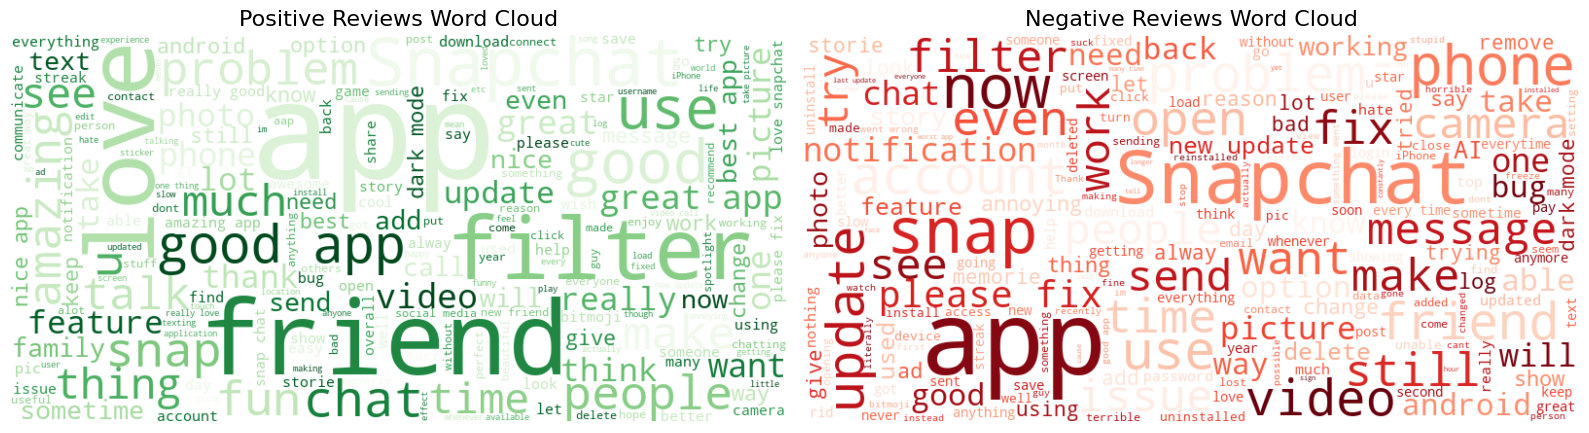

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud for positive reviews
positive_reviews = " ".join(data[data['sentiment'] == 'positive']['content'])
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_reviews)

# Generate word cloud for negative reviews
negative_reviews = " ".join(data[data['sentiment'] == 'negative']['content'])
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews)

# Plot the word clouds
plt.figure(figsize=(16, 8))

# Positive word cloud
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud', fontsize=16)

# Negative word cloud
plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud', fontsize=16)

plt.tight_layout()
plt.show()


In [20]:
# Split data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])

In [21]:
# Model 1: TextBlob Sentiment Analysis
def textblob_sentiment(text):
    analysis = TextBlob(text).sentiment.polarity
    if analysis > 0.2:
        return 'positive'
    elif analysis < -0.2:
        return 'negative'
    else:
        return 'neutral'

train_data['textblob_prediction'] = train_data['content'].apply(textblob_sentiment)
test_data['textblob_prediction'] = test_data['content'].apply(textblob_sentiment)

In [22]:
# Model 2: Vader Sentiment Analysis
vader = SentimentIntensityAnalyzer()
def vader_sentiment(text):
    scores = vader.polarity_scores(text)
    compound = scores['compound']
    if compound > 0.1:
        return 'positive'
    elif compound < -0.1:
        return 'negative'
    else:
        return 'neutral'

train_data['vader_prediction'] = train_data['content'].apply(vader_sentiment)
test_data['vader_prediction'] = test_data['content'].apply(vader_sentiment)

In [23]:
# Model 3: Logistic Regression with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
pipeline = make_pipeline(tfidf_vectorizer, logistic_model)

In [24]:
# Train the model
pipeline.fit(train_data['content'], train_data['sentiment'])

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=5000, stop_words='english')),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [25]:
# Predict on test data
test_data['logistic_prediction'] = pipeline.predict(test_data['content'])

In [26]:
# Evaluate performance of all models
print("TextBlob Classification Report:\n")
print(classification_report(test_data['sentiment'], test_data['textblob_prediction']))

TextBlob Classification Report:

              precision    recall  f1-score   support

    negative       0.81      0.20      0.32     11766
     neutral       0.17      0.55      0.25      3600
    positive       0.69      0.72      0.71     10527

    accuracy                           0.46     25893
   macro avg       0.56      0.49      0.43     25893
weighted avg       0.67      0.46      0.47     25893



In [27]:
print("Vader Classification Report:\n")
print(classification_report(test_data['sentiment'], test_data['vader_prediction']))

Vader Classification Report:

              precision    recall  f1-score   support

    negative       0.74      0.48      0.58     11766
     neutral       0.15      0.14      0.14      3600
    positive       0.59      0.84      0.69     10527

    accuracy                           0.58     25893
   macro avg       0.49      0.49      0.47     25893
weighted avg       0.60      0.58      0.57     25893



In [28]:
print("Logistic Regression Classification Report:\n")
print(classification_report(test_data['sentiment'], test_data['logistic_prediction']))

Logistic Regression Classification Report:

              precision    recall  f1-score   support

    negative       0.73      0.89      0.80     11766
     neutral       0.37      0.06      0.11      3600
    positive       0.79      0.82      0.80     10527

    accuracy                           0.75     25893
   macro avg       0.63      0.59      0.57     25893
weighted avg       0.70      0.75      0.71     25893



In [29]:
# Determine the best-performing model
textblob_accuracy = accuracy_score(test_data['sentiment'], test_data['textblob_prediction'])
vader_accuracy = accuracy_score(test_data['sentiment'], test_data['vader_prediction'])
logistic_accuracy = accuracy_score(test_data['sentiment'], test_data['logistic_prediction'])

print("TextBlob Accuracy:", textblob_accuracy)
print("Vader Accuracy:", vader_accuracy)
print("Logistic Regression Accuracy:", logistic_accuracy)

TextBlob Accuracy: 0.4607422855598038
Vader Accuracy: 0.5798478353222879
Logistic Regression Accuracy: 0.7458772641254393


In [30]:
if textblob_accuracy > vader_accuracy and textblob_accuracy > logistic_accuracy:
    print("TextBlob performs best.")
elif vader_accuracy > textblob_accuracy and vader_accuracy > logistic_accuracy:
    print("Vader performs best.")
elif logistic_accuracy > textblob_accuracy and logistic_accuracy > vader_accuracy:
    print("Logistic Regression performs best.")
else:
    print("Multiple models perform equally well.")


Logistic Regression performs best.


In [31]:
# Print sample results
test_data[['content', 'sentiment', 'textblob_prediction', 'vader_prediction', 'logistic_prediction']].tail()


,content,sentiment,textblob_prediction,vader_prediction,logistic_prediction
114944,"need more video time, like 2 1/2 or 3 minutes....",positive,positive,positive,positive
81241,I give this app a full five star i dont need t...,positive,positive,positive,positive
119899,Awesome experience since 3 yrs. using this app...,positive,positive,positive,positive
66833,snapchat isnt even working rn I cant text anyb...,negative,neutral,negative,negative
59515,Really good app to text your friends would be ...,positive,positive,positive,positive


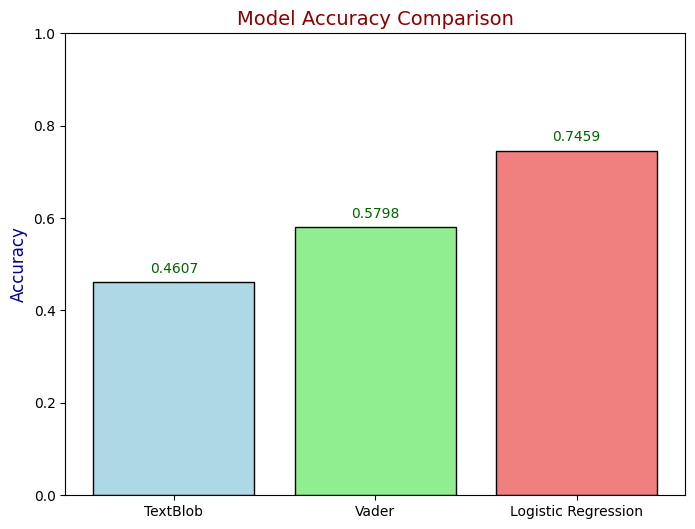

In [32]:
# Accuracy Comparison Bar Chart
def plot_accuracy_comparison(textblob_acc, vader_acc, logistic_acc):
    accuracies = {
        "TextBlob": textblob_acc,
        "Vader": vader_acc,
        "Logistic Regression": logistic_acc
    }
    plt.figure(figsize=(8, 6))
    plt.bar(accuracies.keys(), accuracies.values(), color=['lightblue', 'lightgreen', 'lightcoral'], edgecolor='black')
    plt.title("Model Accuracy Comparison", fontsize=14, color='darkred')
    plt.ylabel("Accuracy", fontsize=12, color='darkblue')
    plt.ylim(0, 1)
    for i, v in enumerate(accuracies.values()):
        plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10, color='darkgreen')
    plt.show()

# Plot accuracy comparison
plot_accuracy_comparison(textblob_accuracy, vader_accuracy, logistic_accuracy)

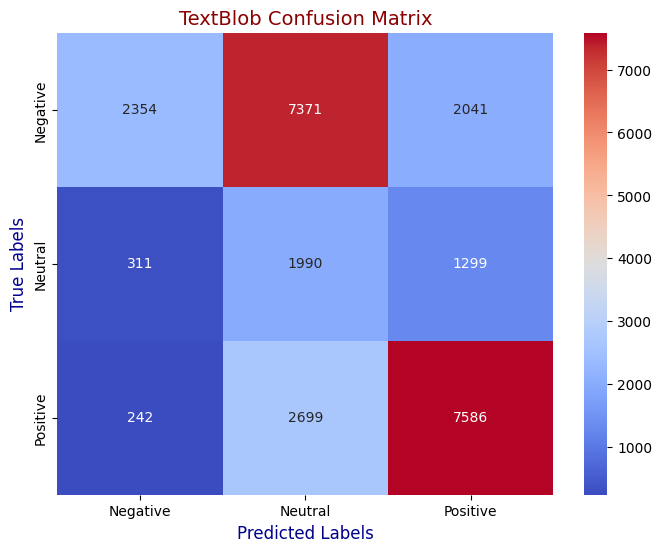

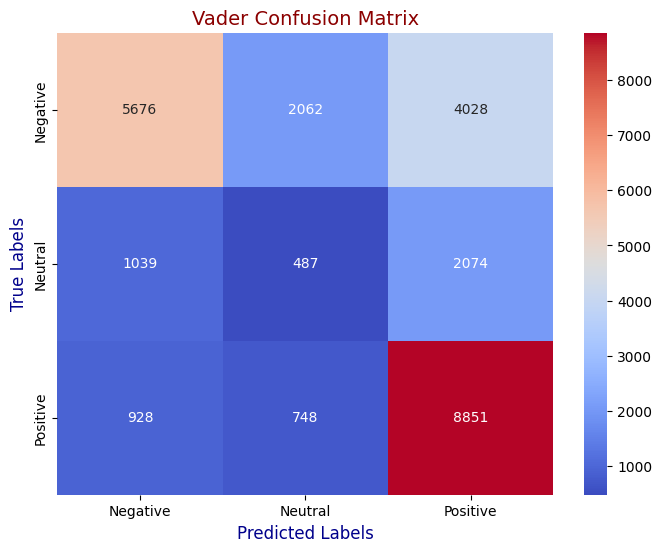

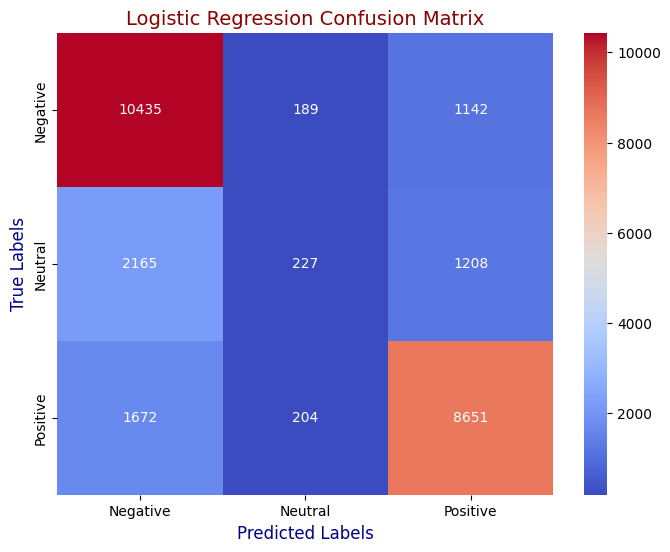

In [33]:
# Confusion Matrix Heatmaps
def plot_confusion_matrix_heatmap(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred, labels=['negative', 'neutral', 'positive'])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f"{model_name} Confusion Matrix", fontsize=14, color='darkred')
    plt.xlabel("Predicted Labels", fontsize=12, color='darkblue')
    plt.ylabel("True Labels", fontsize=12, color='darkblue')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix_heatmap(test_data['sentiment'], test_data['textblob_prediction'], "TextBlob")
plot_confusion_matrix_heatmap(test_data['sentiment'], test_data['vader_prediction'], "Vader")
plot_confusion_matrix_heatmap(test_data['sentiment'], test_data['logistic_prediction'], "Logistic Regression")


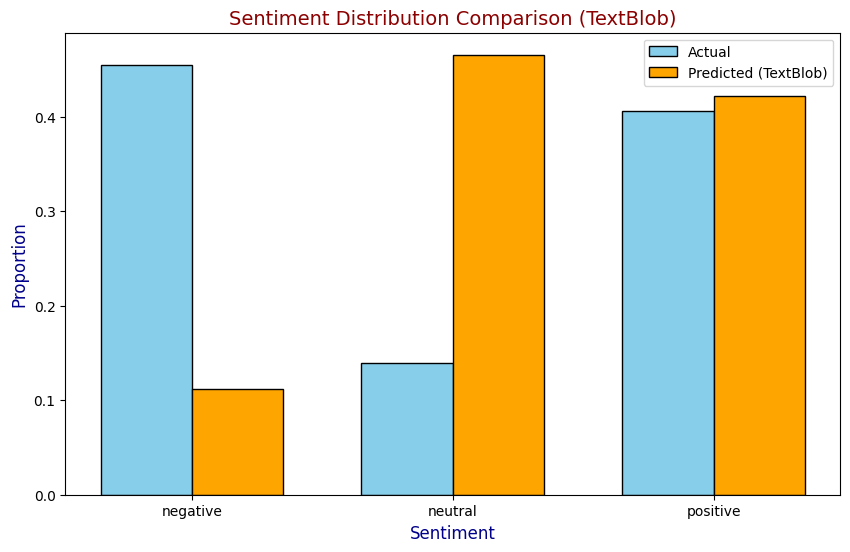

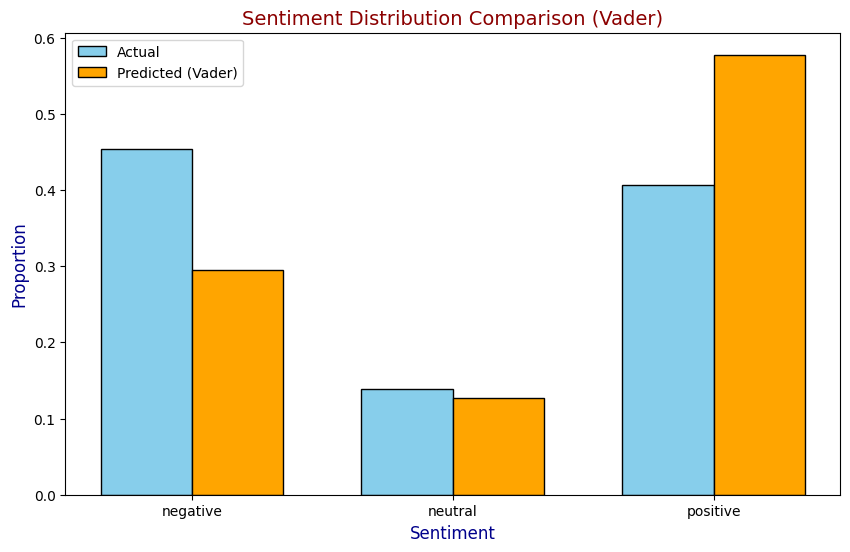

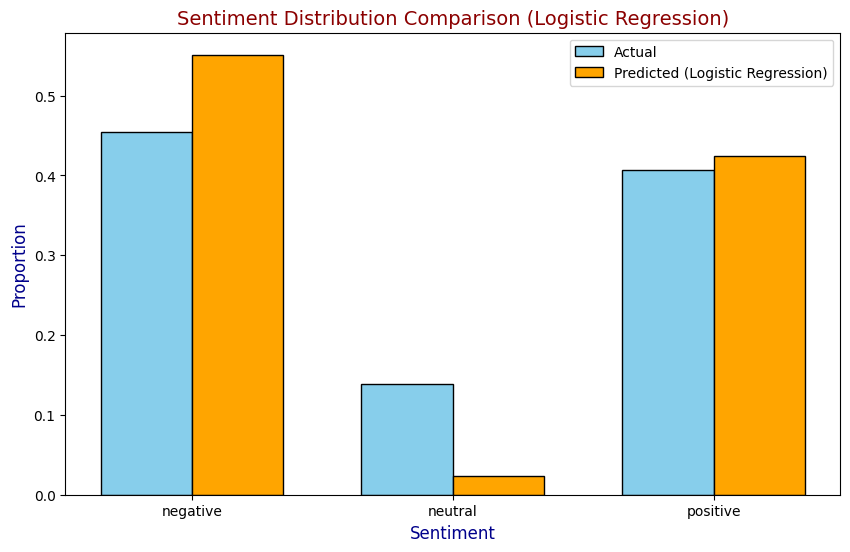

In [34]:
# Sentiment Distribution Comparison
def plot_sentiment_distribution(test_data, model_col, model_name):
    actual_counts = test_data['sentiment'].value_counts(normalize=True)
    predicted_counts = test_data[model_col].value_counts(normalize=True)
    labels = ['negative', 'neutral', 'positive']

    actual_values = [actual_counts.get(label, 0) for label in labels]
    predicted_values = [predicted_counts.get(label, 0) for label in labels]

    x = range(len(labels))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x, actual_values, width, label='Actual', color='skyblue', edgecolor='black')
    plt.bar([i + width for i in x], predicted_values, width, label=f'Predicted ({model_name})', color='orange', edgecolor='black')
    plt.xticks([i + width / 2 for i in x], labels)
    plt.title(f"Sentiment Distribution Comparison ({model_name})", fontsize=14, color='darkred')
    plt.xlabel("Sentiment", fontsize=12, color='darkblue')
    plt.ylabel("Proportion", fontsize=12, color='darkblue')
    plt.legend()
    plt.show()

# Plot sentiment distribution for each model
plot_sentiment_distribution(test_data, 'textblob_prediction', "TextBlob")
plot_sentiment_distribution(test_data, 'vader_prediction', "Vader")
plot_sentiment_distribution(test_data, 'logistic_prediction', "Logistic Regression")


In [35]:


# Cohen's Kappa
cohen_kappa = cohen_kappa_score(test_data['sentiment'], test_data['logistic_prediction'])
print(f"Cohen's Kappa: {cohen_kappa:.4f}")

# RMSE (Root Mean Squared Error)
def calculate_rmse(y_true, y_pred):
    numerical_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    y_true_num = y_true.map(numerical_mapping)
    y_pred_num = y_pred.map(numerical_mapping)
    return np.sqrt(mean_squared_error(y_true_num, y_pred_num))

rmse = calculate_rmse(test_data['sentiment'], test_data['logistic_prediction'])
print(f"RMSE: {rmse:.4f}")

# RSS (Residual Sum of Squares)
def calculate_rss(y_true, y_pred):
    numerical_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    y_true_num = y_true.map(numerical_mapping)
    y_pred_num = y_pred.map(numerical_mapping)
    residuals = y_true_num - y_pred_num
    return np.sum(residuals ** 2)

rss = calculate_rss(test_data['sentiment'], test_data['logistic_prediction'])
print(f"RSS: {rss}")

# Sensitivity and Specificity
def calculate_sensitivity_specificity(y_true, y_pred, label):
    true_positive = ((y_true == label) & (y_pred == label)).sum()
    false_negative = ((y_true == label) & (y_pred != label)).sum()
    false_positive = ((y_true != label) & (y_pred == label)).sum()
    true_negative = ((y_true != label) & (y_pred != label)).sum()
    
    sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0
    
    return sensitivity, specificity

sensitivity, specificity = calculate_sensitivity_specificity(
    test_data['sentiment'], test_data['logistic_prediction'], label='positive'
)
print(f"Sensitivity (Positive): {sensitivity:.4f}")
print(f"Specificity (Positive): {specificity:.4f}")

# F1-Score
_, _, f1_score, _ = precision_recall_fscore_support(test_data['sentiment'], test_data['logistic_prediction'], average='weighted')
print(f"F1 Score: {f1_score:.4f}")

# MAPE (Mean Absolute Percentage Error)
mape = mean_absolute_percentage_error(
    test_data['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2}),
    test_data['logistic_prediction'].map({'negative': 0, 'neutral': 1, 'positive': 2})
)
print(f"MAPE: {mape:.4f}")


Cohen's Kappa: 0.5569
RMSE: 0.7617
RSS: 15022
Sensitivity (Positive): 0.8218
Specificity (Positive): 0.8471
F1 Score: 0.7059
MAPE: 430131768373198.9375


In [36]:


# Function to calculate metrics

def calculate_metrics(y_true, y_pred):
    numerical_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    y_true_num = y_true.map(numerical_mapping)
    y_pred_num = y_pred.map(numerical_mapping)
    
    # Cohen's Kappa
    cohen_kappa = cohen_kappa_score(y_true, y_pred)

    # RMSE
    rmse = np.sqrt(mean_squared_error(y_true_num, y_pred_num))

    # RSS
    residuals = y_true_num - y_pred_num
    rss = np.sum(residuals ** 2)

    # Sensitivity and Specificity for 'positive'
    true_positive = ((y_true == 'positive') & (y_pred == 'positive')).sum()
    false_negative = ((y_true == 'positive') & (y_pred != 'positive')).sum()
    false_positive = ((y_true != 'positive') & (y_pred == 'positive')).sum()
    true_negative = ((y_true != 'positive') & (y_pred != 'positive')).sum()

    sensitivity = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    specificity = true_negative / (true_negative + false_positive) if (true_negative + false_positive) > 0 else 0

    # F1-Score
    _, _, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    # MAPE
    mape = mean_absolute_percentage_error(y_true_num, y_pred_num)

    return {
        'Cohen Kappa': cohen_kappa,
        'RMSE': rmse,
        'RSS': rss,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'F1 Score': f1_score,
        'MAPE': mape
    }

# Compute metrics for all models
models = {
    'TextBlob': test_data['textblob_prediction'],
    'VADER': test_data['vader_prediction'],
    'Logistic Regression': test_data['logistic_prediction']
}

metrics = {}

for model_name, predictions in models.items():
    metrics[model_name] = calculate_metrics(test_data['sentiment'], predictions)

# Create DataFrame for comparison
metrics_df = pd.DataFrame(metrics).T



# Display metrics table
print("Model Comparison Metrics:")
metrics_df

Model Comparison Metrics:


,Cohen Kappa,RMSE,RSS,Sensitivity,Specificity,F1 Score,MAPE
TextBlob,0.243331,0.896532,20812.0,0.720623,0.782637,0.468664,1.992034e+15
VADER,0.315024,0.997177,25747.0,0.840790,0.602889,0.567863,1.759836e+15
Logistic Regression,0.556871,0.761680,15022.0,0.821792,0.847065,0.705925,4.301318e+14


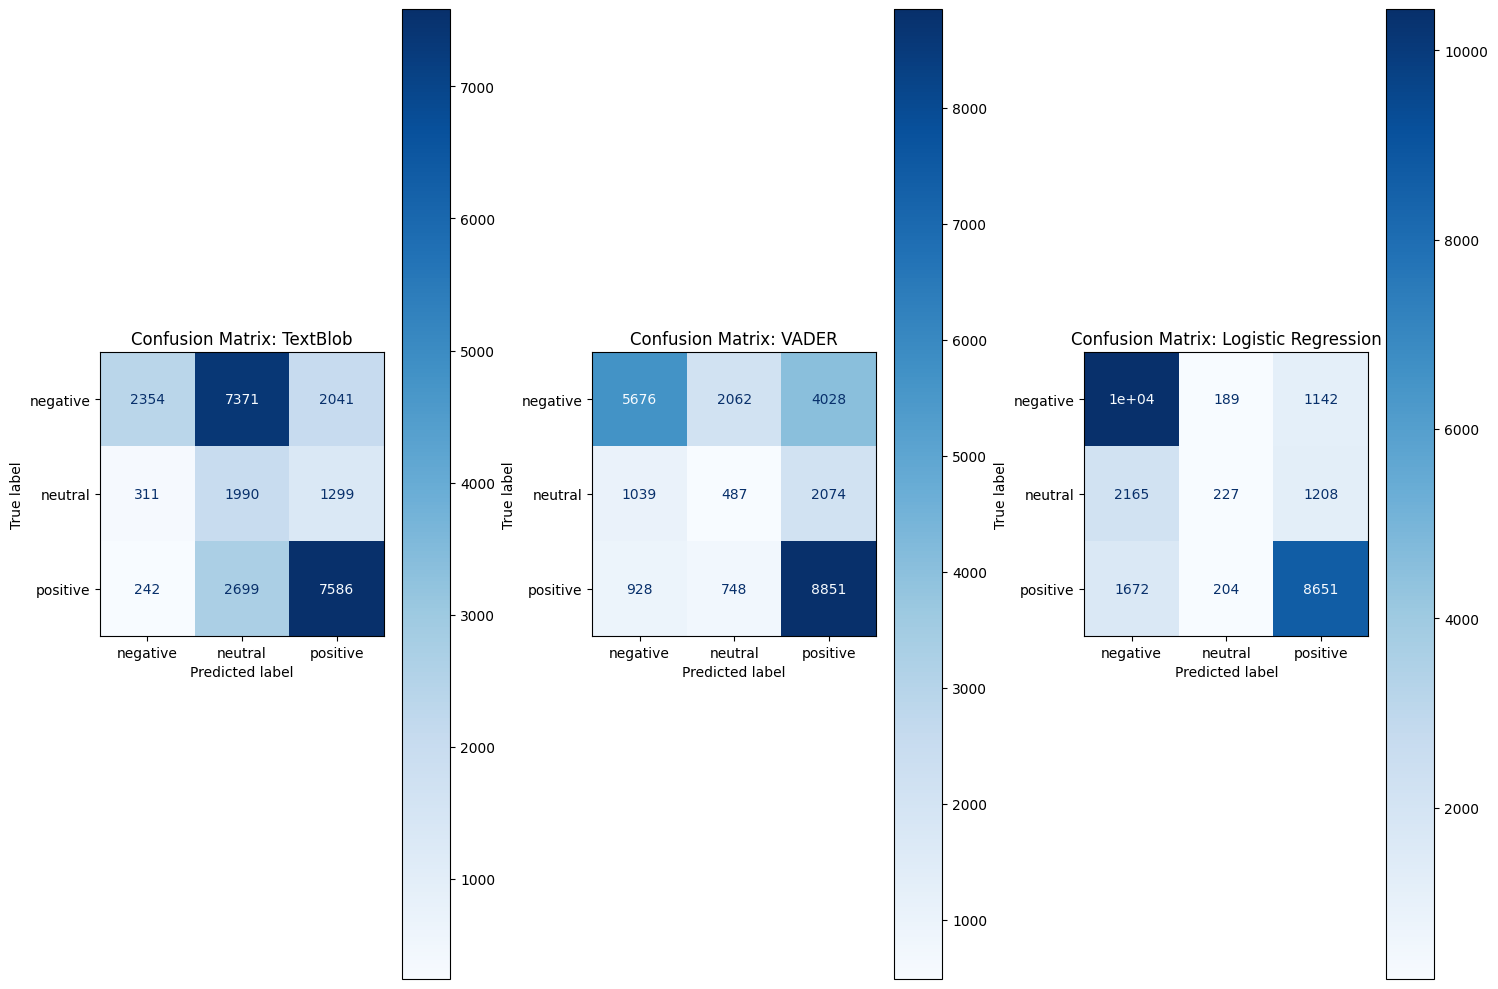

In [37]:




# Binarize the true labels for ROC-AUC computation
classes = ['negative', 'neutral', 'positive']
y_true_binarized = label_binarize(test_data['sentiment'], classes=classes)

# Binarize predictions for ROC curve (TextBlob, VADER, Logistic Regression)
textblob_binarized = label_binarize(test_data['textblob_prediction'], classes=classes)
vader_binarized = label_binarize(test_data['vader_prediction'], classes=classes)
logistic_binarized = label_binarize(test_data['logistic_prediction'], classes=classes)

# Plot confusion matrices
plt.figure(figsize=(15, 10))
for i, (model, predictions) in enumerate(
    zip(
        ['TextBlob', 'VADER', 'Logistic Regression'],
        [test_data['textblob_prediction'], test_data['vader_prediction'], test_data['logistic_prediction']],
    )
):
    ax = plt.subplot(1, 3, i + 1)
    ConfusionMatrixDisplay.from_predictions(
        test_data['sentiment'], predictions, labels=classes, ax=ax, cmap='Blues'
    )
    plt.title(f"Confusion Matrix: {model}")
plt.tight_layout()
plt.show()

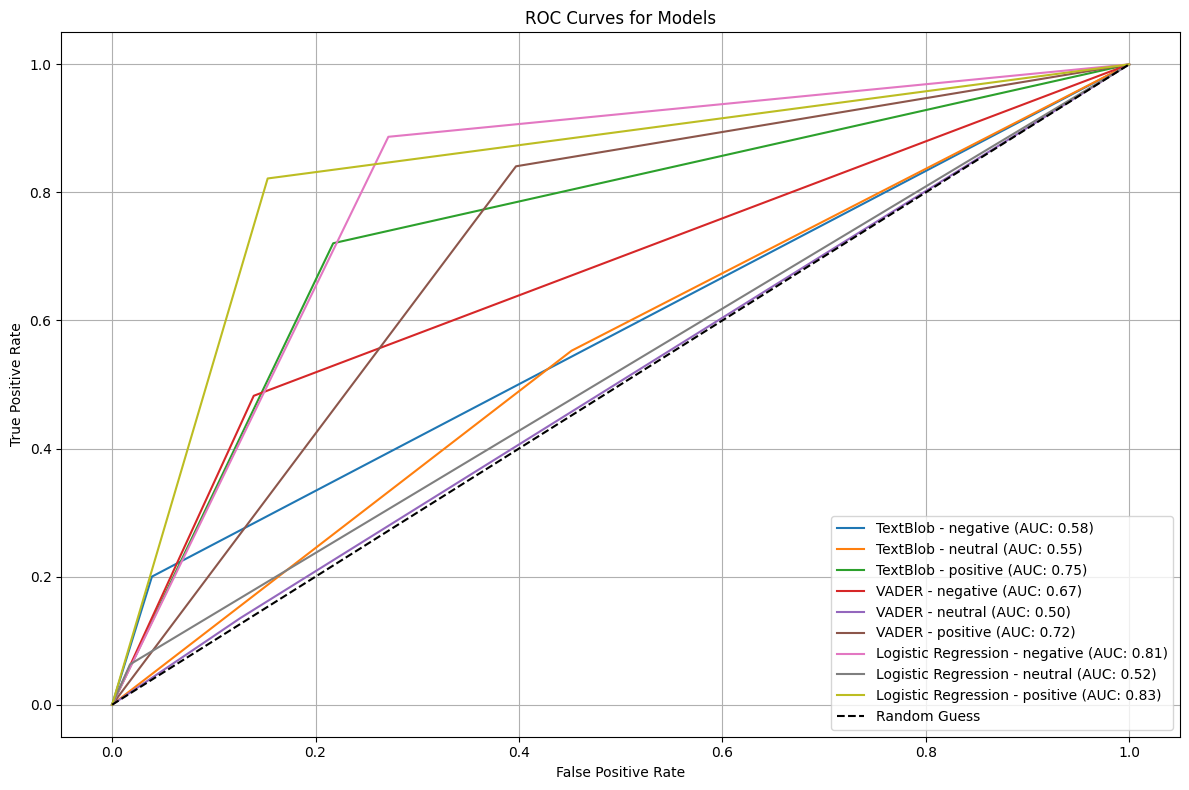

In [38]:
# Compute ROC curves and AUC scores
plt.figure(figsize=(12, 8))

for model_name, predictions_binarized in zip(
    ['TextBlob', 'VADER', 'Logistic Regression'],
    [textblob_binarized, vader_binarized, logistic_binarized],
):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, class_label in enumerate(classes):
        fpr[class_label], tpr[class_label], _ = roc_curve(
            y_true_binarized[:, i], predictions_binarized[:, i]
        )
        roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

        plt.plot(
            fpr[class_label],
            tpr[class_label],
            label=f"{model_name} - {class_label} (AUC: {roc_auc[class_label]:.2f})",
        )

# Plot diagonal
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Models")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()
